In [1]:
import pandas as pd
import CococoNet_reader
from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats
from pydeseq2.utils import load_example_data
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import Name_resolver
import tqdm as tq

In [2]:
def get_ncbi_clean_og2gene_for_species(
    species_1, og2genes_only_cococonet, ncbi_mapping
):

    species_1_name = Name_resolver.species_name_resolver(
        species_1, desired_type="common"
    )

    first_species_ortho_groups = og2genes_only_cococonet.loc[
        og2genes_only_cococonet["Species"] == species_1
    ]
    shared_orthogroups = first_species_ortho_groups["Orthogroup"].unique()

    list_of_orthogene_pds = []
    for orthogroup in tq.tqdm(
        shared_orthogroups, desc="inner_loop", position=0, leave=False
    ):
        species_1_genes = (
            first_species_ortho_groups["Gene"]
            .loc[first_species_ortho_groups["Orthogroup"] == orthogroup]
            .to_list()
        )
        all_gene_combos = species_1_genes
        current_orthogroup_pd = pd.DataFrame(
            columns=[f"{species_1_name} OrthoGene"], data=all_gene_combos
        )
        current_orthogroup_pd["Orthogroup"] = orthogroup
        list_of_orthogene_pds.append(current_orthogroup_pd)

    final_species_lineup = pd.concat(list_of_orthogene_pds)
    ncbi_added_once = final_species_lineup.merge(
        right=ncbi_mapping[["Orthodb Gene", "Symbol"]],
        right_on="Orthodb Gene",
        left_on=f"{species_1_name} OrthoGene",
    )
    ncbi_added_once_clean = ncbi_added_once.drop(columns="Orthodb Gene")
    return ncbi_added_once_clean

In [3]:
og_groups = pd.read_csv(
    "/data/passala/OrthoDB_data/NCBI_data/og_2_Genes_with_ncbi_symbol.csv"
)
og_groups

,Orthogroup,Gene,Species,Ortholevel,Orthodb Gene,Symbol
0,100007at3193,4558_0:003a4f,4558,3193,4558_0:003a4f,LOC110434333
1,100007at3193,4577_0:004254,4577,3193,4577_0:004254,LOC100276500
2,100007at3193,4577_0:004e43,4577,3193,4577_0:004e43,LOC100275058
3,100067at3193,4558_0:00439a,4558,3193,4558_0:00439a,LOC8071983
4,100085at3193,4558_0:002fd8,4558,3193,4558_0:002fd8,LOC8086335
...,...,...,...,...,...,...
502887,9969at3193,15368_0:000e9a,15368,3193,15368_0:000e9a,LOC100834561
502888,99917at3193,39947_0:006297,39947,3193,39947_0:006297,LOC107276177
502889,99917at3193,39947_0:00634f,39947,3193,39947_0:00634f,LOC9269479
502890,99917at3193,39947_0:006629,39947,3193,39947_0:006629,LOC9269626


In [4]:
ncbi_mapping = pd.read_csv(
    "/data/passala/OrthoDB_data/NCBI_data/merged_ncbi_to_orthodb_fixed_non_genesymbol.csv"
)

In [5]:
tomato_og = get_ncbi_clean_og2gene_for_species(
    4081, og_groups, ncbi_mapping=ncbi_mapping
)

inner_loop:   0%|          | 0/13860 [00:00<?, ?it/s]

In [6]:
arabi_og = get_ncbi_clean_og2gene_for_species(
    3702, og_groups, ncbi_mapping=ncbi_mapping
)

inner_loop:   0%|          | 0/15558 [00:00<?, ?it/s]

In [7]:
tomato_og

,tomato OrthoGene,Orthogroup,Symbol
0,4081_0:002534,10009at3193,LOC101245541
1,4081_0:0062c9,10009at3193,LOC101249449
2,4081_0:0044e5,10092at3193,GPA1
3,4081_0:0060db,10147at3193,LOC101260909
4,4081_0:001ce5,10228at3193,LOC101262196
...,...,...,...
25093,4081_0:006159,9877at3193,LOC101260902
25094,4081_0:00201e,9919at3193,LOC101252265
25095,4081_0:000a73,9942at3193,GDI1
25096,4081_0:003f8c,9942at3193,LOC101261051


In [8]:
list_of_non_single_gene_groups_tomato = pd.Series(tomato_og['Orthogroup'].value_counts().loc[tomato_og['Orthogroup'].value_counts() >2])

In [9]:
list_of_non_single_gene_groups_arabi = pd.Series(arabi_og['Orthogroup'].value_counts().loc[arabi_og['Orthogroup'].value_counts() >2])

In [10]:
list_of_non_single_gene_groups_arabi

Orthogroup
71601at3193     30
889985at3193    29
784291at3193    26
305752at3193    26
31749at3193     25
                ..
600787at3193     3
685613at3193     3
110660at3193     3
111222at3193     3
886928at3193     3
Name: count, Length: 2239, dtype: int64

In [11]:
list_of_non_single_gene_groups_tomato

Orthogroup
718886at3193    41
775521at3193    40
866404at3193    33
886969at3193    32
784291at3193    30
                ..
731891at3193     3
889214at3193     3
404557at3193     3
73726at3193      3
130271at3193     3
Name: count, Length: 2356, dtype: int64

In [12]:
tomato_og = tomato_og.loc[tomato_og['Orthogroup'].isin(list_of_non_single_gene_groups_tomato.index)]

In [13]:
arabi_og = arabi_og.loc[arabi_og['Orthogroup'].isin(list_of_non_single_gene_groups_arabi.index)]

In [14]:
arabi_og

,arabidopsis OrthoGene,Orthogroup,Symbol
17,3702_0:000421,10950at3193,AT1G23550
18,3702_0:000a44,10950at3193,AT1G70440
19,3702_0:000d1e,10950at3193,AT1G32230
20,3702_0:00299f,10950at3193,AT2G35510
21,3702_0:006a79,10950at3193,AT5G62520
...,...,...,...
25981,3702_0:00307f,9877at3193,AT3G58750
25982,3702_0:004152,9877at3193,AT3G58740
25984,3702_0:002571,9942at3193,AT2G44100
25985,3702_0:003134,9942at3193,AT3G59920


In [15]:
arabi_csv_uncleaned = pd.read_csv(
    "/data/passala/Module_paper_data/Arabi_tomato_heat_stress_comparison/arabi_data/GSE94015_gene_readCount.txt",
    sep="\t",
)
arabi_csv = arabi_csv_uncleaned[
    [
        "Locus",
        "WtRL0h_rep1",
        "WtRL0h_rep2",
        "WtRL0h_rep3",
        "WtRL3h_rep1",
        "WtRL3h_rep2",
        "WtRL3h_rep3",
    ]
]

arabi_csv = arabi_csv.set_index("Locus")
arabi_csv

,WtRL0h_rep1,WtRL0h_rep2,WtRL0h_rep3,WtRL3h_rep1,WtRL3h_rep2,WtRL3h_rep3
Locus,,,,,,
AT1G01010,92,212,255,79,154,169
AT1G01020,120,288,219,219,354,597
AT1G01030,3,28,15,5,9,14
AT1G01040,889,2127,2189,1041,1788,1807
AT1G01046,12,51,37,8,26,19
...,...,...,...,...,...,...
ATMG01370,18,59,67,218,382,249
ATMG01380,13,8,14,104,136,107
ATMG01390,382,1046,4054,5581,8779,4796


In [16]:
combined_arabi_divert = arabi_csv.copy()

In [17]:
arabi_csv

,WtRL0h_rep1,WtRL0h_rep2,WtRL0h_rep3,WtRL3h_rep1,WtRL3h_rep2,WtRL3h_rep3
Locus,,,,,,
AT1G01010,92,212,255,79,154,169
AT1G01020,120,288,219,219,354,597
AT1G01030,3,28,15,5,9,14
AT1G01040,889,2127,2189,1041,1788,1807
AT1G01046,12,51,37,8,26,19
...,...,...,...,...,...,...
ATMG01370,18,59,67,218,382,249
ATMG01380,13,8,14,104,136,107
ATMG01390,382,1046,4054,5581,8779,4796


In [18]:
dict_version = arabi_og[['Orthogroup','Symbol']].set_index('Symbol').to_dict()
true_dict = dict_version['Orthogroup']
arabi_csv = arabi_csv.groupby(by = true_dict).mean()

In [19]:
arabi_metadata = pd.DataFrame(
    columns=["Temp"],
    data=["Cold", "Cold", "Cold", "Hot", "Hot", "Hot"],
    index=[
        "WtRL0h_rep1",
        "WtRL0h_rep2",
        "WtRL0h_rep3",
        "WtRL3h_rep1",
        "WtRL3h_rep2",
        "WtRL3h_rep3",
    ],
)

In [20]:
low_heat_tomato_1 = pd.read_csv(
    "/data/passala/Module_paper_data/Arabi_tomato_heat_stress_comparison/low_heat_tomato/tomato_no_heat_stress_1ReadsPerGene.out.tab",
    sep="\t",
    index_col=0,
    skiprows=4,
    header=None,
    names=["Reads", "Left Reads", "Right reads"],
)
low_heat_tomato_2 = pd.read_csv(
    "/data/passala/Module_paper_data/Arabi_tomato_heat_stress_comparison/low_heat_tomato/tomato_no_heat_stress_2ReadsPerGene.out.tab",
    sep="\t",
    index_col=0,
    skiprows=4,
    header=None,
    names=["Reads", "Left Reads", "Right reads"],
)
low_heat_tomato_3 = pd.read_csv(
    "/data/passala/Module_paper_data/Arabi_tomato_heat_stress_comparison/low_heat_tomato/tomato_no_heat_stress_3ReadsPerGene.out.tab",
    sep="\t",
    index_col=0,
    skiprows=4,
    header=None,
    names=["Reads", "Left Reads", "Right reads"],
)

low_heat_tomato = pd.DataFrame(
    data=zip(
        low_heat_tomato_1["Reads"],
        low_heat_tomato_2["Reads"],
        low_heat_tomato_3["Reads"],
    ),
    columns=["Tom Cold Rep 1", "Tom Cold Rep 2", "Tom Cold Rep 3"],
    index=low_heat_tomato_1.index,
)

In [21]:
high_heat_tomato_rep_1 = pd.read_csv(
    "/data/passala/Module_paper_data/Arabi_tomato_heat_stress_comparison/high_heat_tomato/tomato_heat_stress_1ReadsPerGene.out.tab",
    sep="\t",
    index_col=0,
    skiprows=4,
    header=None,
    names=["Reads", "Left Reads", "Right reads"],
)
high_heat_tomato_rep_2 = pd.read_csv(
    "/data/passala/Module_paper_data/Arabi_tomato_heat_stress_comparison/high_heat_tomato/tomato_heat_stress_2ReadsPerGene.out.tab",
    sep="\t",
    index_col=0,
    skiprows=4,
    header=None,
    names=["Reads", "Left Reads", "Right reads"],
)
high_heat_tomato_rep_3 = pd.read_csv(
    "/data/passala/Module_paper_data/Arabi_tomato_heat_stress_comparison/high_heat_tomato/tomato_heat_stress_3ReadsPerGene.out.tab",
    sep="\t",
    index_col=0,
    skiprows=4,
    header=None,
    names=["Reads", "Left Reads", "Right reads"],
)
high_heat_tomato = pd.DataFrame(
    data=zip(
        high_heat_tomato_rep_1["Reads"],
        high_heat_tomato_rep_2["Reads"],
        high_heat_tomato_rep_3["Reads"],
    ),
    columns=["Tom Hot Rep 1", "Tom Hot Rep 2", "Tom Hot Rep 3"],
    index=low_heat_tomato_1.index,
)

In [22]:
combined_tomato = pd.concat([high_heat_tomato, low_heat_tomato], axis=1)

In [23]:
combined_tomato_divert = combined_tomato.copy()

In [24]:
dict_version = tomato_og[['Orthogroup','Symbol']].set_index('Symbol').to_dict()
true_dict = dict_version['Orthogroup']
combined_tomato = combined_tomato.groupby(by = true_dict).mean()

In [25]:
combined_tomato

,Tom Hot Rep 1,Tom Hot Rep 2,Tom Hot Rep 3,Tom Cold Rep 1,Tom Cold Rep 2,Tom Cold Rep 3
10772at3193,2269.333333,2057.333333,2378.333333,2540.666667,2389.666667,2945.000000
10950at3193,1117.333333,827.888889,648.222222,803.666667,867.000000,719.222222
109808at3193,177.333333,124.666667,90.000000,161.666667,181.333333,111.666667
109859at3193,21.666667,31.333333,33.333333,64.000000,54.666667,62.666667
109895at3193,8.500000,7.000000,8.750000,5.250000,5.375000,2.750000
...,...,...,...,...,...,...
9592at3193,606.333333,437.666667,442.333333,542.333333,531.666667,447.666667
9601at3193,705.000000,660.000000,648.000000,1333.666667,1418.666667,1275.666667
9609at3193,27.000000,42.750000,58.500000,130.000000,101.500000,185.250000
9789at3193,1853.666667,1533.666667,1182.666667,346.666667,368.000000,389.666667


In [26]:
combined_tomato = combined_tomato.T
arabi_csv = arabi_csv.T

In [27]:
combined_tomato = combined_tomato.round(0)
arabi_csv = arabi_csv.round(0)

In [28]:
tomato_metadata = pd.DataFrame(
    columns=["Temp"],
    data=["Hot", "Hot", "Hot", "Cold", "Cold", "Cold"],
    index=[
        "Tom Hot Rep 1",
        "Tom Hot Rep 2",
        "Tom Hot Rep 3",
        "Tom Cold Rep 1",
        "Tom Cold Rep 2",
        "Tom Cold Rep 3",
    ],
)

In [29]:
genes_to_keep_arabi = arabi_csv.columns[arabi_csv.sum(axis=0) >= 100]
arabi_csv = arabi_csv[genes_to_keep_arabi]
inference_arabi = DefaultInference(n_cpus=30)
dds_arabi = DeseqDataSet(
    counts=arabi_csv,
    metadata=arabi_metadata,
    design_factors="Temp",
    refit_cooks=True,
    inference=inference_arabi,
)
dds_arabi.deseq2()
stat_res_arabi = DeseqStats(dds_arabi, inference=inference_arabi)
stat_res_arabi.summary()

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 0.26 seconds.

Fitting dispersion trend curve...
... done in 0.07 seconds.

Fitting MAP dispersions...
... done in 0.28 seconds.

Fitting LFCs...
... done in 0.21 seconds.

Refitting 0 outliers.

Running Wald tests...
... done in 0.18 seconds.



Log2 fold change & Wald test p-value: Temp Hot vs Cold
                 baseMean  log2FoldChange     lfcSE      stat    pvalue  \
Locus                                                                     
10950at3193   2117.544930       -0.035878  0.248588 -0.144328  0.885241   
109808at3193    78.019323        0.929422  0.498435  1.864683  0.062226   
109843at3193  1012.280567        0.281584  0.251094  1.121427  0.262106   
110108at3193   362.197126       -0.643508  0.507235 -1.268658  0.204563   
110263at3193   413.266330       -0.249289  0.214669 -1.161271  0.245532   
...                   ...             ...       ...       ...       ...   
9592at3193     575.061761        0.699836  0.196538  3.560812  0.000370   
9601at3193     366.788308       -0.204587  0.185666 -1.101907  0.270502   
9609at3193     786.316558        0.104964  0.264219  0.397261  0.691175   
9877at3193    1060.333108        0.608849  0.199816  3.047053  0.002311   
9942at3193    2157.483162        0.125647  0.

In [30]:
genes_to_keep = combined_tomato.columns[combined_tomato.sum(axis=0) >= 100]
combined_tomato = combined_tomato[genes_to_keep]
inference = DefaultInference(n_cpus=30)
dds = DeseqDataSet(
    counts=combined_tomato,
    metadata=tomato_metadata,
    design_factors="Temp",
    refit_cooks=True,
    inference=inference,
)
dds.deseq2()
stat_res = DeseqStats(dds, inference=inference)
stat_res.summary()

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 0.16 seconds.

Fitting dispersion trend curve...
... done in 0.06 seconds.

Fitting MAP dispersions...
... done in 0.16 seconds.

Fitting LFCs...
... done in 0.17 seconds.

Refitting 0 outliers.

Running Wald tests...


Log2 fold change & Wald test p-value: Temp Hot vs Cold
                 baseMean  log2FoldChange     lfcSE      stat        pvalue  \
10772at3193   2450.346409       -0.463596  0.181620 -2.552557  1.069355e-02   
10950at3193    820.953574       -0.126100  0.192539 -0.654930  5.125128e-01   
109808at3193   140.364526       -0.455828  0.286738 -1.589702  1.119021e-01   
109859at3193    46.038966       -1.306142  0.352386 -3.706561  2.100927e-04   
109997at3193   179.619514       -1.439948  0.259779 -5.542964  2.973933e-08   
...                   ...             ...       ...       ...           ...   
9592at3193     499.026848       -0.268884  0.174269 -1.542929  1.228481e-01   
9601at3193    1031.260474       -1.231811  0.124719 -9.876713  5.252769e-23   
9609at3193      95.587275       -1.925882  0.403038 -4.778415  1.766826e-06   
9789at3193     892.098827        1.801654  0.180802  9.964774  2.173680e-23   
9942at3193     753.746495        0.565467  0.140154  4.034615  5.469184e-05 

... done in 0.16 seconds.



In [31]:
full_results = stat_res.results_df
full_results
full_arabi_results = stat_res_arabi.results_df

In [32]:
#full_results.to_csv('/data/passala/Module_paper_data/Arabi_tomato_heat_stress_comparison/Ortho_vs_gene_files/tomato_ortho_trimmed_out_2_gene_families.csv')
#full_arabi_results.to_csv('/data/passala/Module_paper_data/Arabi_tomato_heat_stress_comparison/Ortho_vs_gene_files/arabi_ortho_trimmed_out_2_gene_families.csv')


In [33]:
random_species_1 = tomato_og.copy()
random_species_2 = arabi_og.copy()

species_1_metadata = tomato_metadata.copy()
species_2_metadata = arabi_metadata.copy()

species_1_csv = combined_tomato_divert
species_1_csv = species_1_csv

species_2_csv = combined_arabi_divert
species_2_csv = species_2_csv


random_species_1 ['Symbol'] = random_species_1['Symbol'].sample(frac = 1).values
random_species_2 ['Symbol'] = random_species_2['Symbol'].sample(frac = 1).values

list_of_non_single_gene_groups_species_1 =  pd.Series(random_species_1['Orthogroup'].value_counts().loc[random_species_1['Orthogroup'].value_counts() >1])
list_of_non_single_gene_groups_species_2 = pd.Series(random_species_2['Orthogroup'].value_counts().loc[random_species_2['Orthogroup'].value_counts() > 1])
random_species_1 = random_species_1.loc[random_species_1['Orthogroup'].isin(list_of_non_single_gene_groups_species_1.index)]
random_species_2 = random_species_2.loc[random_species_2['Orthogroup'].isin(list_of_non_single_gene_groups_species_2.index)]

dict_version_species_1 = random_species_1[['Orthogroup','Symbol']].set_index('Symbol').to_dict()
true_dict_species_1 = dict_version_species_1['Orthogroup']
combined_species_1 = species_1_csv.groupby(by = true_dict_species_1).mean()

dict_version_species_2 = random_species_2[['Orthogroup','Symbol']].set_index('Symbol').to_dict()
true_dict_species_2 = dict_version_species_2['Orthogroup']
combined_species_2 = species_2_csv.groupby(by = true_dict_species_2).mean()

combined_species_1 = combined_species_1.T
combined_species_2 = combined_species_2.T

combined_species_1 = combined_species_1.round(0)
combined_species_2 = combined_species_2.round(0)

genes_to_keep_species_1 = combined_species_1.columns[combined_species_1.sum(axis=0) >= 100]
combined_species_1 = combined_species_1[genes_to_keep_species_1]
inference = DefaultInference(n_cpus=30)
dds_species_1 = DeseqDataSet(
    counts=combined_species_1,
    metadata=species_1_metadata,
    design_factors="Temp",
    refit_cooks=True,
    inference=inference,
)
dds_species_1.deseq2()
stat_res_species_1 = DeseqStats(dds_species_1, inference=inference)
stat_res_species_1.summary()

genes_to_keep_species_2 = combined_species_2.columns[combined_species_2.sum(axis=0) >= 100]
combined_species_2 = combined_species_2[genes_to_keep_species_2]
inference = DefaultInference(n_cpus=30)
dds_species_2 = DeseqDataSet(
    counts=combined_species_2,
    metadata=species_2_metadata,
    design_factors="Temp",
    refit_cooks=True,
    inference=inference,
)
dds_species_2.deseq2()
stat_res_species_2 = DeseqStats(dds_species_2, inference=inference)
stat_res_species_2.summary()

full_results_species_1 = stat_res_species_1.results_df
full_results_species_2 = stat_res_species_2.results_df

full_results_species_1.to_csv('/data/passala/Module_paper_data/Arabi_tomato_heat_stress_comparison/Ortho_vs_gene_files/tomato_random.csv')
full_results_species_2.to_csv('/data/passala/Module_paper_data/Arabi_tomato_heat_stress_comparison/Ortho_vs_gene_files/arabi_random.csv')

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 0.24 seconds.

Fitting dispersion trend curve...
... done in 0.07 seconds.

Fitting MAP dispersions...
... done in 0.21 seconds.

Fitting LFCs...
... done in 0.19 seconds.

Refitting 0 outliers.

Running Wald tests...
... done in 0.18 seconds.



Log2 fold change & Wald test p-value: Temp Hot vs Cold
                 baseMean  log2FoldChange     lfcSE      stat        pvalue  \
10772at3193    233.107013       -1.241263  0.223840 -5.545319  2.934180e-08   
10950at3193   5488.204147       -1.567001  0.310572 -5.045531  4.522629e-07   
109808at3193    48.227906        0.202125  0.309453  0.653169  5.136476e-01   
109859at3193    59.337757       -0.792314  0.282285 -2.806788  5.003821e-03   
109895at3193  4855.339200        0.406535  0.196136  2.072723  3.819808e-02   
...                   ...             ...       ...       ...           ...   
9499at3193    1200.175580       -2.195120  0.388932 -5.643965  1.661782e-08   
9592at3193     294.866887        0.193645  0.164020  1.180622  2.377528e-01   
9609at3193     130.646515        0.068489  0.185068  0.370073  7.113280e-01   
9789at3193     167.933798        2.447661  0.303712  8.059163  7.681870e-16   
9942at3193     475.861204       -0.849954  0.226470 -3.753056  1.746919e-04 

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 0.21 seconds.

Fitting dispersion trend curve...
... done in 0.07 seconds.

Fitting MAP dispersions...
... done in 0.22 seconds.

Fitting LFCs...
... done in 0.20 seconds.

Refitting 0 outliers.

Running Wald tests...


Log2 fold change & Wald test p-value: Temp Hot vs Cold
                 baseMean  log2FoldChange     lfcSE      stat    pvalue  \
Locus                                                                     
10950at3193     47.218761       -0.041438  0.327164 -0.126657  0.899212   
109808at3193    75.246378        0.394288  0.261315  1.508864  0.131334   
109843at3193    98.756752       -1.472523  0.311877 -4.721483  0.000002   
109895at3193  1269.689714        0.388100  0.294311  1.318671  0.187279   
110016at3193   195.207022        0.528156  0.344656  1.532413  0.125420   
...                   ...             ...       ...       ...       ...   
9592at3193      91.924037        0.410566  0.330065  1.243892  0.213539   
9601at3193     495.072364        0.013697  0.256802  0.053337  0.957464   
9609at3193      28.314144        0.074273  0.413917  0.179440  0.857592   
9877at3193      25.489412        0.520447  0.608922  0.854702  0.392716   
9942at3193     312.419339        0.754729  0.

... done in 0.19 seconds.



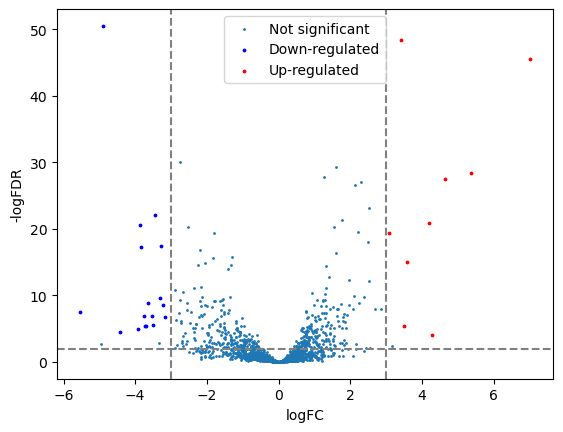

In [106]:
plt.scatter(
    x=full_arabi_results["log2FoldChange"],
    y=full_arabi_results["padj"].apply(lambda x: -np.log10(x)),
    s=1,
    label="Not significant",
)

# highlight down- or up- regulated genes
down_arabi = full_arabi_results[
    (full_arabi_results["log2FoldChange"] <= -3)
    & (full_arabi_results["padj"] <= 0.0001)
]
up_arabi = full_arabi_results[
    (full_arabi_results["log2FoldChange"] >= 3) & (full_arabi_results["padj"] <= 0.0001)
]

plt.scatter(
    x=down_arabi["log2FoldChange"],
    y=down_arabi["padj"].apply(lambda x: -np.log10(x)),
    s=3,
    label="Down-regulated",
    color="blue",
)
plt.scatter(
    x=up_arabi["log2FoldChange"],
    y=up_arabi["padj"].apply(lambda x: -np.log10(x)),
    s=3,
    label="Up-regulated",
    color="red",
)
plt.xlabel("logFC")
plt.ylabel("-logFDR")
plt.axvline(-3, color="grey", linestyle="--")
plt.axvline(3, color="grey", linestyle="--")
plt.axhline(2, color="grey", linestyle="--")
plt.legend()

In [59]:
up_arabi

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
Locus,,,,,,
110893at3193,80.372282,4.285144,0.448552,9.553284,1.256489e-21,1.054948e-19
115912at3193,34.113117,4.855805,0.742600,6.538921,6.196439e-11,1.667478e-09
128908at3193,53.107943,3.789943,0.836267,4.531979,5.843352e-06,5.275353e-05
13579at3193,28.498034,3.262833,0.713802,4.571063,4.852559e-06,4.428487e-05
137296at3193,4485.512685,7.020351,0.747533,9.391359,5.923108e-21,4.362317e-19
138566at3193,33.803358,4.483831,0.752304,5.960129,2.520395e-09,4.835530e-08
208588at3193,103.642330,4.552161,0.402493,11.309903,1.172188e-29,2.050352e-27
218751at3193,3590.153245,6.055543,0.459908,13.166863,1.361368e-39,5.715022e-37
22623at3193,23.086506,3.400070,0.685846,4.957482,7.141275e-07,7.973157e-06


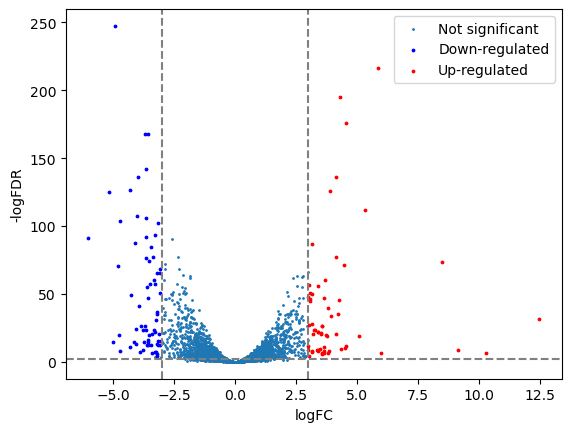

In [60]:
plt.scatter(
    x=full_results["log2FoldChange"],
    y=full_results["padj"].apply(lambda x: -np.log10(x)),
    s=1,
    label="Not significant",
)

# highlight down- or up- regulated genes
down = full_results[
    (full_results["log2FoldChange"] <= -3) & (full_results["padj"] <= 0.0001)
]
up = full_results[
    (full_results["log2FoldChange"] >= 3) & (full_results["padj"] <= 0.0001)
]

plt.scatter(
    x=down["log2FoldChange"],
    y=down["padj"].apply(lambda x: -np.log10(x)),
    s=3,
    label="Down-regulated",
    color="blue",
)
plt.scatter(
    x=up["log2FoldChange"],
    y=up["padj"].apply(lambda x: -np.log10(x)),
    s=3,
    label="Up-regulated",
    color="red",
)
plt.xlabel("logFC")
plt.ylabel("-logFDR")
plt.axvline(-3, color="grey", linestyle="--")
plt.axvline(3, color="grey", linestyle="--")
plt.axhline(2, color="grey", linestyle="--")
plt.legend()

In [61]:
up

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
110152at3193,25.663803,3.158197,0.543566,5.810141,6.242021e-09,2.731304e-08
110291at3193,2880.161235,3.023206,0.269875,11.202246,3.975232e-29,8.202700e-28
110469at3193,124.424842,3.553103,0.321172,11.062937,1.897800e-28,3.781646e-27
115760at3193,96.131638,3.672407,0.521901,7.036598,1.969897e-12,1.255115e-11
117233at3193,86.188174,3.266432,0.314472,10.387051,2.839976e-25,4.636347e-24
...,...,...,...,...,...,...
882708at3193,3689.642475,4.292571,0.142558,30.110956,3.482725e-199,4.719092e-196
884613at3193,1952.957950,3.065858,0.199740,15.349283,3.581242e-53,2.274648e-51
885125at3193,609.235554,3.165120,0.157592,20.084302,1.012366e-89,1.789247e-87
885995at3193,8034.459578,3.012436,0.202659,14.864540,5.599789e-50,3.035085e-48
